# 1. **Introduction**

The goal of this project is to predict whether a Spotify user will churn (cancel their subscription) or remain active.

# 2. **Configuration**

- Import the required libraries  
- Download the dataset  
- Set the appropriate data types  
- Separate variables into different objects 

In [2]:
# Libraries
import kagglehub
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")

In [2]:
# Download dataset
path = kagglehub.dataset_download("nabihazahid/spotify-dataset-for-churn-analysis")

df_raw = pd.read_csv(f"{path}/spotify_churn_dataset.csv")
df_raw.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [3]:
# Set data types
print(df_raw.dtypes)

df_raw = df_raw.astype({
    "user_id": "str",
    "gender": "category",
    "country": "category",
    "subscription_type": "category",
    "device_type": "category",
    "offline_listening": "bool",
    "is_churned": "bool"
})




user_id                    int64
gender                    object
age                        int64
country                   object
subscription_type         object
listening_time             int64
songs_played_per_day       int64
skip_rate                float64
device_type               object
ads_listened_per_week      int64
offline_listening          int64
is_churned                 int64
dtype: object


In [4]:
# Separate variables into different objects 

quantitative_cols = ["age", "listening_time", "songs_played_per_day","skip_rate","ads_listened_per_week"]
string_cols = ["user_id"]
categorical_cols = ["gender", "country", "subscription_type","device_type"]
boolean_cols = ["offline_listening"]

target = ["is_churned"]

# 3. **Exploratory Data Analysis (EDA)**

Perform an initial exploration of the dataset to understand distributions, detect missing values, and identify key patterns.  


## A. **General**

All rows contain complete information across all columns. Out of 8,000 users, 2,071 are labeled as churned.


In [5]:
# Check nulls
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   user_id                8000 non-null   object  
 1   gender                 8000 non-null   category
 2   age                    8000 non-null   int64   
 3   country                8000 non-null   category
 4   subscription_type      8000 non-null   category
 5   listening_time         8000 non-null   int64   
 6   songs_played_per_day   8000 non-null   int64   
 7   skip_rate              8000 non-null   float64 
 8   device_type            8000 non-null   category
 9   ads_listened_per_week  8000 non-null   int64   
 10  offline_listening      8000 non-null   bool    
 11  is_churned             8000 non-null   bool    
dtypes: bool(2), category(4), float64(1), int64(4), object(1)
memory usage: 422.8+ KB


In [6]:
# Target variable distribution
df_raw["is_churned"].value_counts()

is_churned
False    5929
True     2071
Name: count, dtype: int64

## B. **Descriptive Statistics**

### Quantitative Variables

- Users are on average 38 years old, with half of them between 26 and 49 years old (adult profile).  
- On average, users listen to music for around 154 minutes per day. However, the standard deviation is 84 minutes, indicating high heterogeneity.  
- The number of songs played per day ranges from 1 to 99, with an average of 55 songs. The distribution is approximately symmetric (Q1 = 25, Q3 = 75).  
- On average, 30% of the songs are skipped.  
- The number of ads listened to per week is a special case, as only users on the free plan hear ads. The maximum observed value is 49 ads per week.  

**Average user profile**: An adult who listens to music for about 2.5 hours a day (around 50 songs), skipping 30% of them.


In [7]:
df_raw[quantitative_cols].describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
age,8000.0,37.662,12.740,16.0,26.00,38.0,49.00,59.0
listening_time,8000.0,154.068,84.016,10.0,81.00,154.0,227.00,299.0
songs_played_per_day,8000.0,50.127,28.450,1.0,25.00,50.0,75.00,99.0
skip_rate,8000.0,0.300,0.174,0.0,0.15,0.3,0.45,0.6
ads_listened_per_week,8000.0,6.944,13.618,0.0,0.00,0.0,5.00,49.0


If we look at the differences by the target variable, we find that:

- There are no differences in age.  
- Active users listen to about 1.5 minutes more on average, which is not a significant difference.  
- A similar conclusion is reached when looking at the number of songs played per day: users who cancel their subscription listen to 2 more songs on average.  
- The skip rate is identical between both groups: 0.3.  
- The number of ads listened are 6.96 for active users and 6.89 for churned users.



In [8]:
df_raw.groupby("is_churned")[quantitative_cols].agg(["mean", "median"]).round(3)


age        listening_time        songs_played_per_day         \
              mean median           mean median                 mean median   
is_churned                                                                    
False       37.632   38.0        154.447  155.0               49.971   50.0   
True        37.748   38.0        152.985  153.0               50.576   52.0   

           skip_rate        ads_listened_per_week         
                mean median                  mean median  
is_churned                                                
False          0.298   0.30                 6.962    0.0  
True           0.305   0.31                 6.891    0.0

### Categorical Variables

All categorical variables are well distributed across their categories, which is a positive indicator.  

Only *offline listening* shows a biased distribution: 74.8% of users are offline listeners. This is expected, since users on the free plan do not have access to this option.  


In [9]:
cat_bool_features = categorical_cols + boolean_cols 

descriptives = {}

for col in cat_bool_features:
    counts = df_raw[col].value_counts(dropna=False)
    perc = df_raw[col].value_counts(normalize=True, dropna=False) * 100
    
    descriptives[col] = pd.DataFrame({
        "count": counts,
        "percentage": perc.round(2)
    })

for col, desc in descriptives.items():
    print(f"\n=== {col} ===")
    print(desc)


=== gender ===
        count  percentage
gender                   
Male     2691       33.64
Female   2659       33.24
Other    2650       33.12

=== country ===
         count  percentage
country                   
AU        1034       12.92
US        1032       12.90
DE        1015       12.69
IN        1011       12.64
PK         999       12.49
FR         989       12.36
UK         966       12.08
CA         954       11.92

=== subscription_type ===
                   count  percentage
subscription_type                   
Premium             2115       26.44
Free                2018       25.22
Student             1959       24.49
Family              1908       23.85

=== device_type ===
             count  percentage
device_type                   
Desktop       2778       34.72
Web           2623       32.79
Mobile        2599       32.49

=== offline_listening ===
                   count  percentage
offline_listening                   
True                5982       74.78
Fals

## C. **Outliers**

As we can see, no outliers are detected in most variables. The only exception is *ads listened per week*, which shows outliers. However, this has a clear explanation: only users on the free plan are exposed to ads.  


In [10]:
outlier_counts = []

for col in quantitative_cols:
    # Compute Q1 and Q3 
    q1 = df_raw[col].quantile(0.25)
    q3 = df_raw[col].quantile(0.75)
    
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    # Count outliers
    count = df_raw[(df_raw[col] < lower) | (df_raw[col] > upper)].shape[0]
    
    outlier_counts.append({"column": col, "n_outliers": count})

# DataFrame
outlier_summary = pd.DataFrame(outlier_counts)
print(outlier_summary)



                  column  n_outliers
0                    age           0
1         listening_time           0
2   songs_played_per_day           0
3              skip_rate           0
4  ads_listened_per_week        1683


If we analyze the variable *ads listened* only for users on the free plan, no outliers are detected.

In [11]:
# Free users
df_free = df_raw[df_raw["subscription_type"] == "Free"].copy()

col = "ads_listened_per_week"

# Q1, Q3 and IQR
q1 = df_free[col].quantile(0.25)
q3 = df_free[col].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Identify outliers
outliers = df_free[(df_free[col] < lower) | (df_free[col] > upper)]

print(f"Outliers in {col} (only Free users): {outliers.shape[0]}")
print(outliers[[col]].describe())

Outliers in ads_listened_per_week (only Free users): 0
       ads_listened_per_week
count                    0.0
mean                     NaN
std                      NaN
min                      NaN
25%                      NaN
50%                      NaN
75%                      NaN
max                      NaN


## D. **Normality Assumption**

All variables behave approximately normally (symmetric, light tails).  
To study the distribution of the *ads* column, only users on the free plan were analyzed.  

In [ ]:
stats_data = []

for col in quantitative_cols:
    if col == "ads_listened_per_week":
        series = df_raw.loc[df_raw["subscription_type"] == "Free", col].dropna().to_numpy()
    else:
        series = df_raw[col].dropna().to_numpy()

    stats_data.append({
        "column": col,
        "skew": skew(series, nan_policy="omit"),
        "kurtosis": kurtosis(series, nan_policy="omit"),
        "skew_result": (
            "approx. symmetric" if -0.5 <= skew(series, nan_policy="omit") <= 0.5 else
            "moderately skewed" if -1 <= skew(series, nan_policy="omit") <= 1 else
            "highly skewed"
        ),
        "kurtosis_result": (
            "approx. normal" if -2 <= kurtosis(series, nan_policy="omit") <= 2 else
            "heavy tails (leptokurtic)" if kurtosis(series, nan_policy="omit") > 2 else
            "light tails (platykurtic)"
        )
    })

norm_stats = pd.DataFrame(stats_data)
print(norm_stats.round(3))

                  column   skew  kurtosis        skew_result kurtosis_result
0                    age -0.027    -1.211  approx. symmetric  approx. normal
1         listening_time  0.010    -1.214  approx. symmetric  approx. normal
2   songs_played_per_day -0.004    -1.192  approx. symmetric  approx. normal
3              skip_rate  0.006    -1.195  approx. symmetric  approx. normal
4  ads_listened_per_week -0.055    -1.234  approx. symmetric  approx. normal


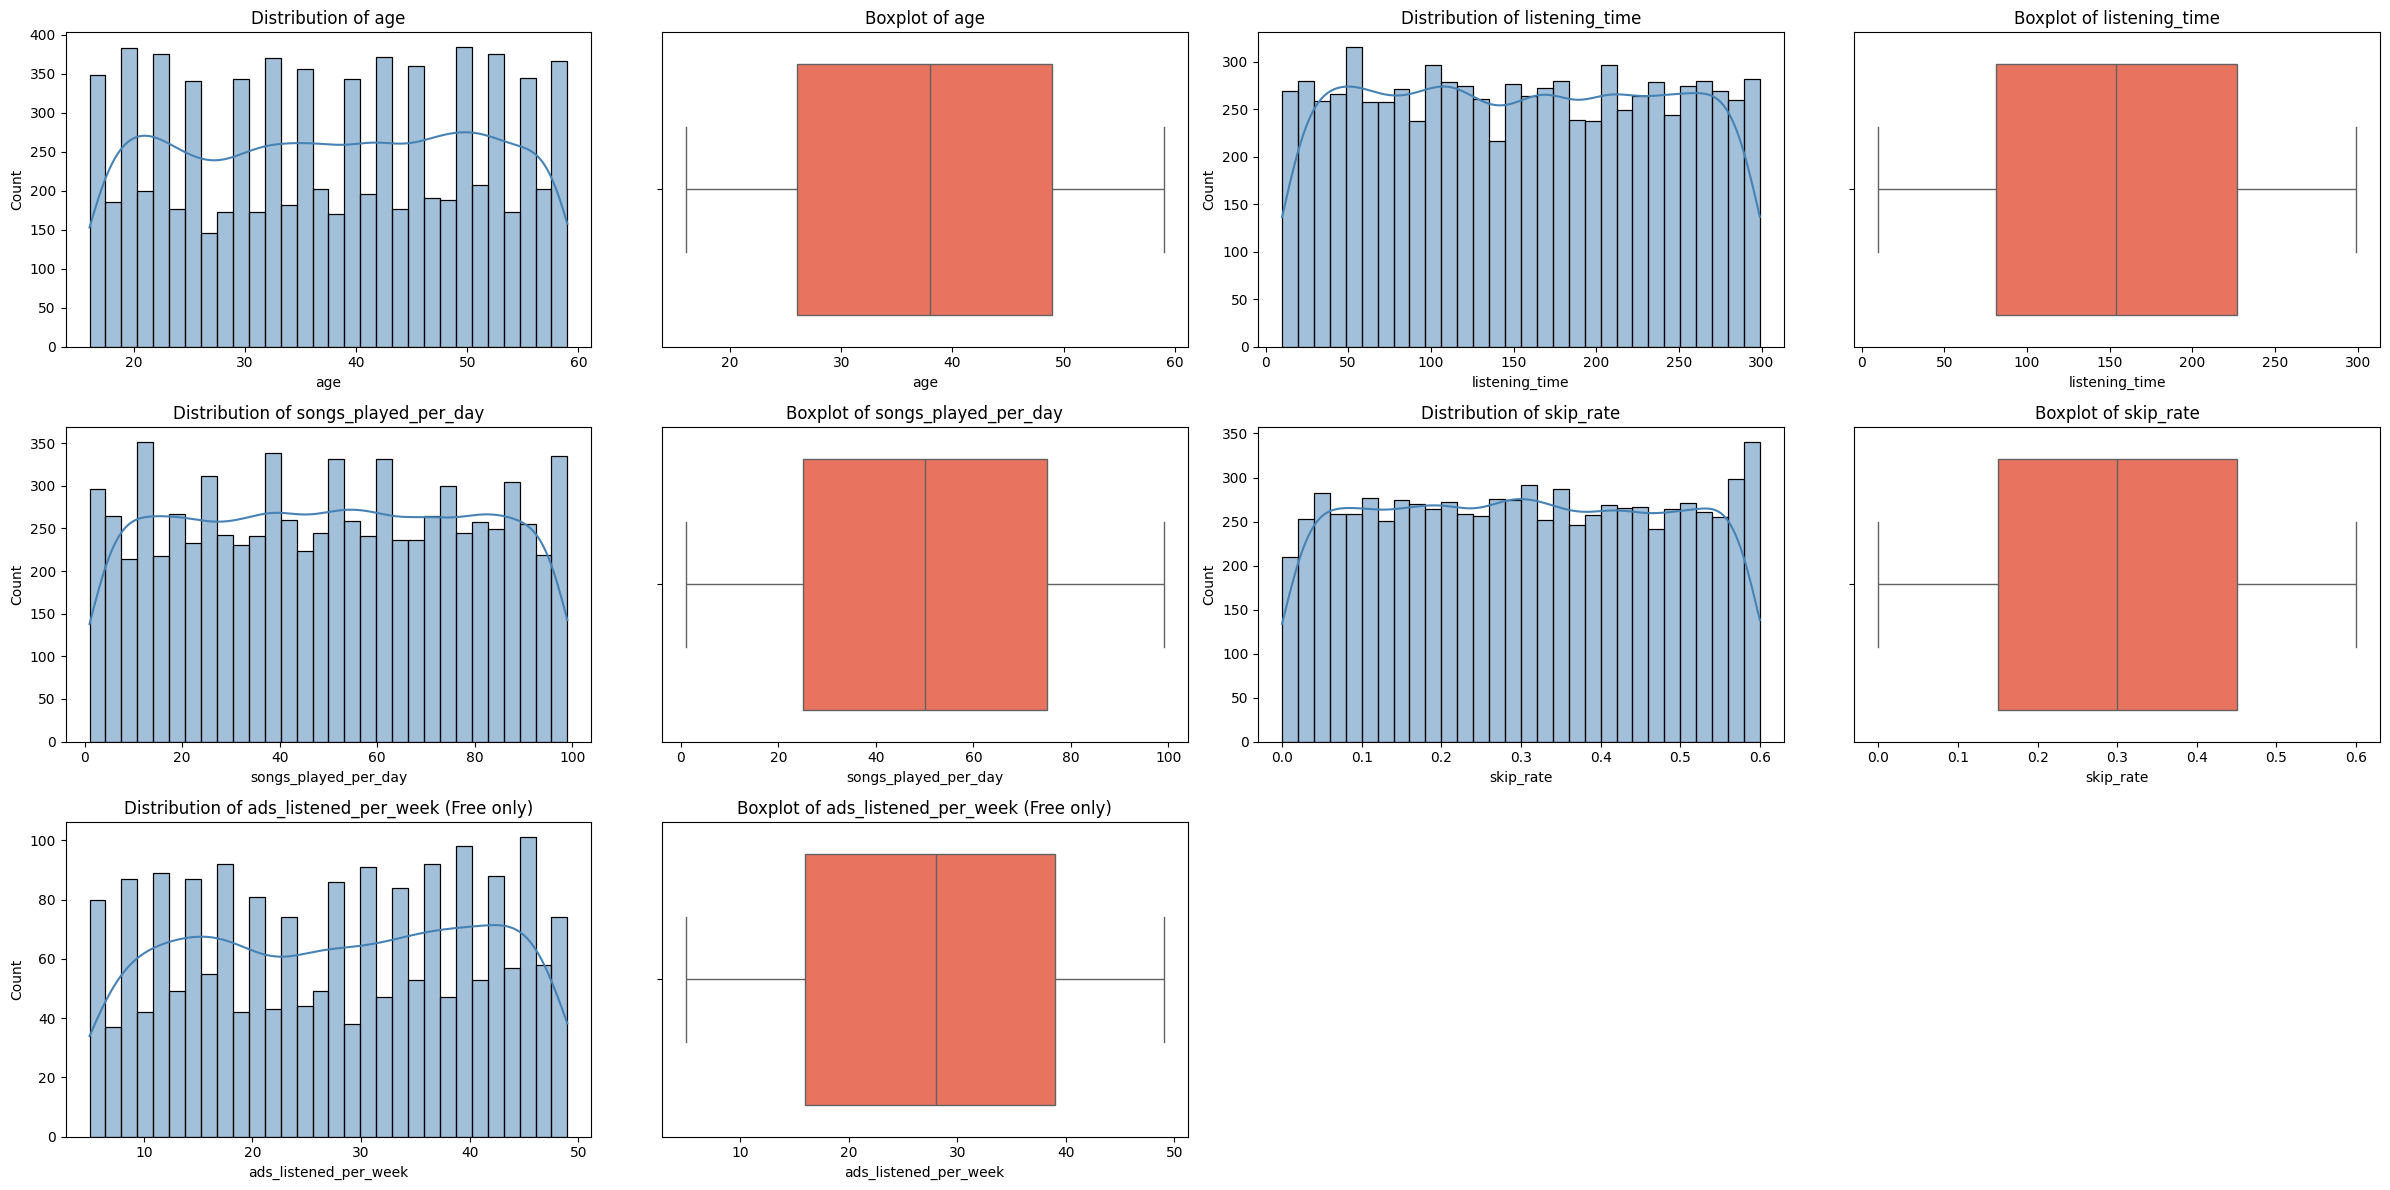

In [13]:
ncols = 4  
nrows = int(len(quantitative_cols) / 2) + (len(quantitative_cols) % 2 > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))

axes = axes.reshape(nrows, ncols)

for i, col in enumerate(quantitative_cols):
    # Row and position
    row = i // 2
    colpos = (i % 2) * 2

    if col == "ads_listened_per_week":
        series_pd = df_raw.loc[df_raw["subscription_type"] == "Free", col].dropna()
        title_suffix = " (Free only)"
    else:
        series_pd = df_raw[col].dropna()
        title_suffix = ""

    # Histogram
    sns.histplot(series_pd, kde=True, ax=axes[row][colpos], color="steelblue", bins=30)
    axes[row][colpos].set_title(f"Distribution of {col}{title_suffix}")

    # Boxplot
    sns.boxplot(x=series_pd, ax=axes[row][colpos+1], color="tomato")
    axes[row][colpos+1].set_title(f"Boxplot of {col}{title_suffix}")

# Delete empty subplots (odd number)
total_plots = len(quantitative_cols) * 2
for j in range(total_plots, nrows*ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


## E. **Correlations**

This section explores the relationships between variables to identify potential multicollinearity and meaningful associations.

### Correlations Between Target and Predictors

Overall, the relationships are very weak.  
This suggests that more complex models are needed to capture interactions and non-linear patterns.  

In [14]:
# Correlation with VD
correlations = {}

# Quantitative
for col in quantitative_cols:
    correlations[col] = df_raw[col].corr(df_raw["is_churned"])

# Booleanas
for col in boolean_cols:
    correlations[col] = df_raw[col].astype(int).corr(df_raw["is_churned"].astype(int))

# Categorics (one-hot)
df_dummies = pd.get_dummies(df_raw[categorical_cols], drop_first=True)

for col in df_dummies.columns:
    correlations[col] = df_dummies[col].corr(df_raw["is_churned"])

# Union all
correlations_df = pd.DataFrame({
    "variable": list(correlations.keys()),
    "corr_with_churn": list(correlations.values())
})

print(correlations_df.sort_values("corr_with_churn", key=abs, ascending=False).round(3))



                     variable  corr_with_churn
3                   skip_rate            0.016
18         device_type_Mobile            0.016
12                 country_PK            0.014
11                 country_IN           -0.014
19            device_type_Web           -0.013
15     subscription_type_Free           -0.013
5           offline_listening            0.013
9                  country_DE            0.012
16  subscription_type_Premium           -0.011
6                 gender_Male           -0.011
10                 country_FR            0.011
13                 country_UK           -0.010
2        songs_played_per_day            0.009
8                  country_CA           -0.009
1              listening_time           -0.008
7                gender_Other            0.005
14                 country_US           -0.004
0                         age            0.004
17  subscription_type_Student            0.004
4       ads_listened_per_week           -0.002


### Correlation Between Predictors

Most of the **quantitative variables** are weakly correlated, meaning they provide distinct information.  
A strong negative correlation is observed between offline listening and the number of ads listened: the more users listen offline, the fewer ads they are exposed to.  

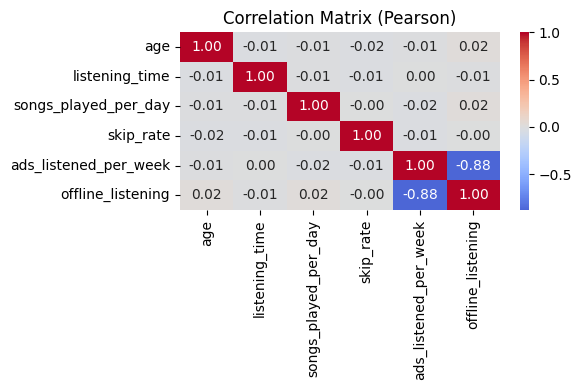

In [15]:
# Pearson
corr_matrix = df_raw[quantitative_cols + boolean_cols].corr(method="pearson")

plt.figure(figsize=(6,4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)
plt.title("Correlation Matrix (Pearson)")
plt.tight_layout()
plt.show()

Regarding **categorical variables** association:

- The correlation between subscription type and offline listening is perfect, since free plan users do not have the option of offline listening.  
- The other variables show a homogeneous distribution with respect to the rest.  

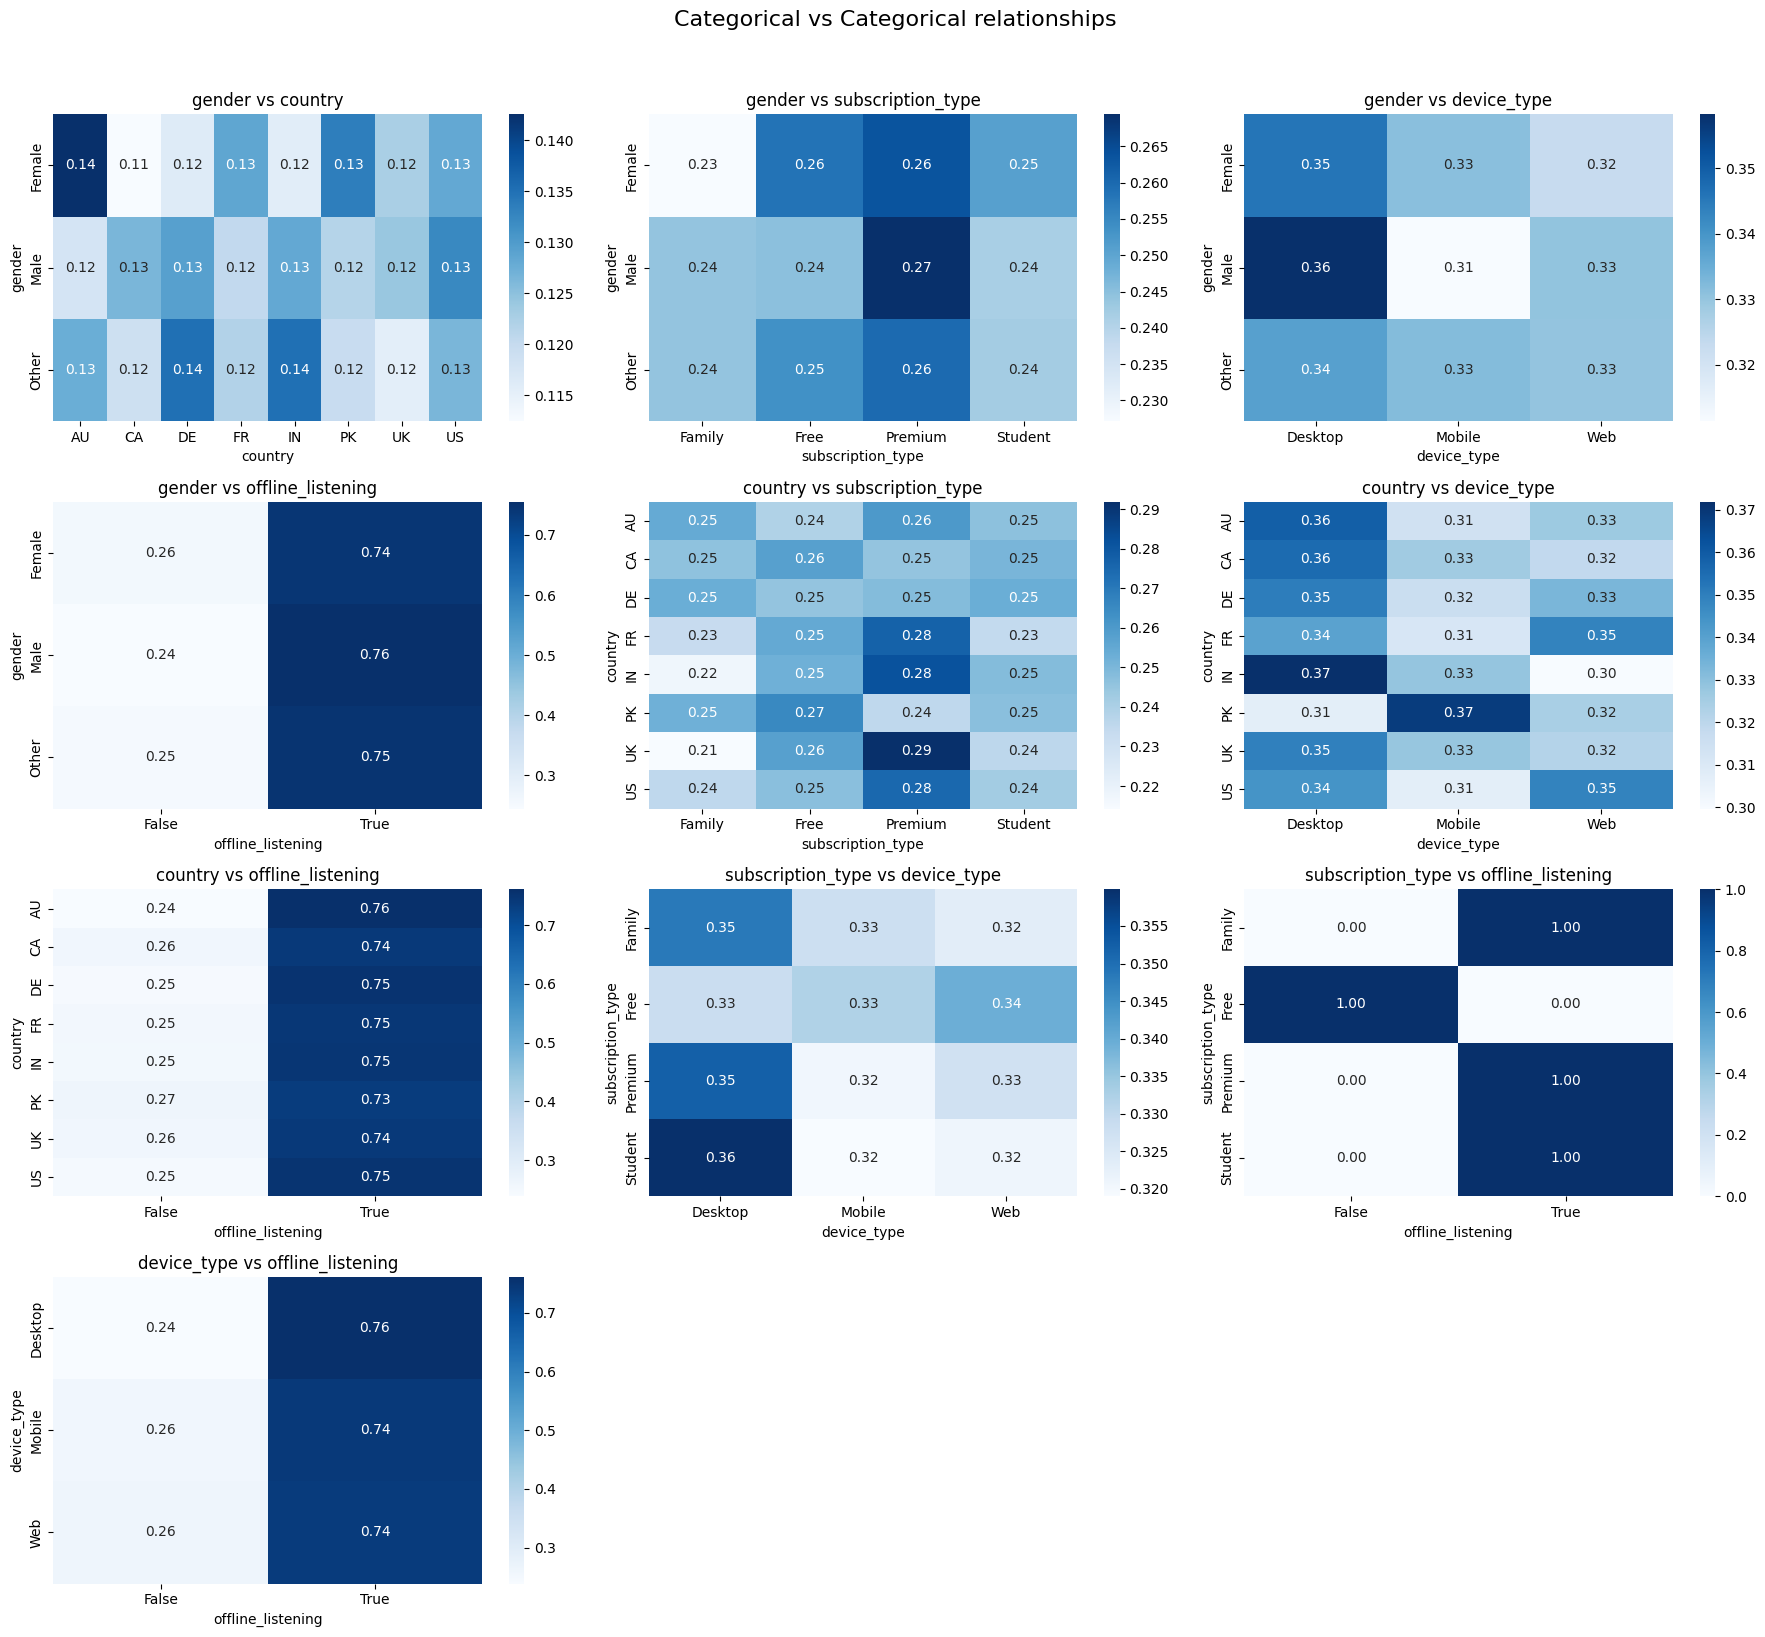

In [16]:
import itertools

# Categorical
cat_features = [c for c in (categorical_cols + string_cols + boolean_cols) if c not in ["user_id"]]

# Combinations 2x2
pairs = list(itertools.combinations(cat_features, 2))

ncols = 3
nrows = int(len(pairs) / ncols) + (len(pairs) % ncols > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
axes = axes.flatten()

for i, (col1, col2) in enumerate(pairs):
    ctab = pd.crosstab(df_raw[col1], df_raw[col2], normalize="index")
    sns.heatmap(ctab, annot=True, cmap="Blues", fmt=".2f", ax=axes[i])
    axes[i].set_title(f"{col1} vs {col2}")
    axes[i].set_ylabel(col1)
    axes[i].set_xlabel(col2)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Categorical vs Categorical relationships", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

There is no strong relationship between **quantitative and categorical variables**.  
No visible differences are observed in the target variable either.  

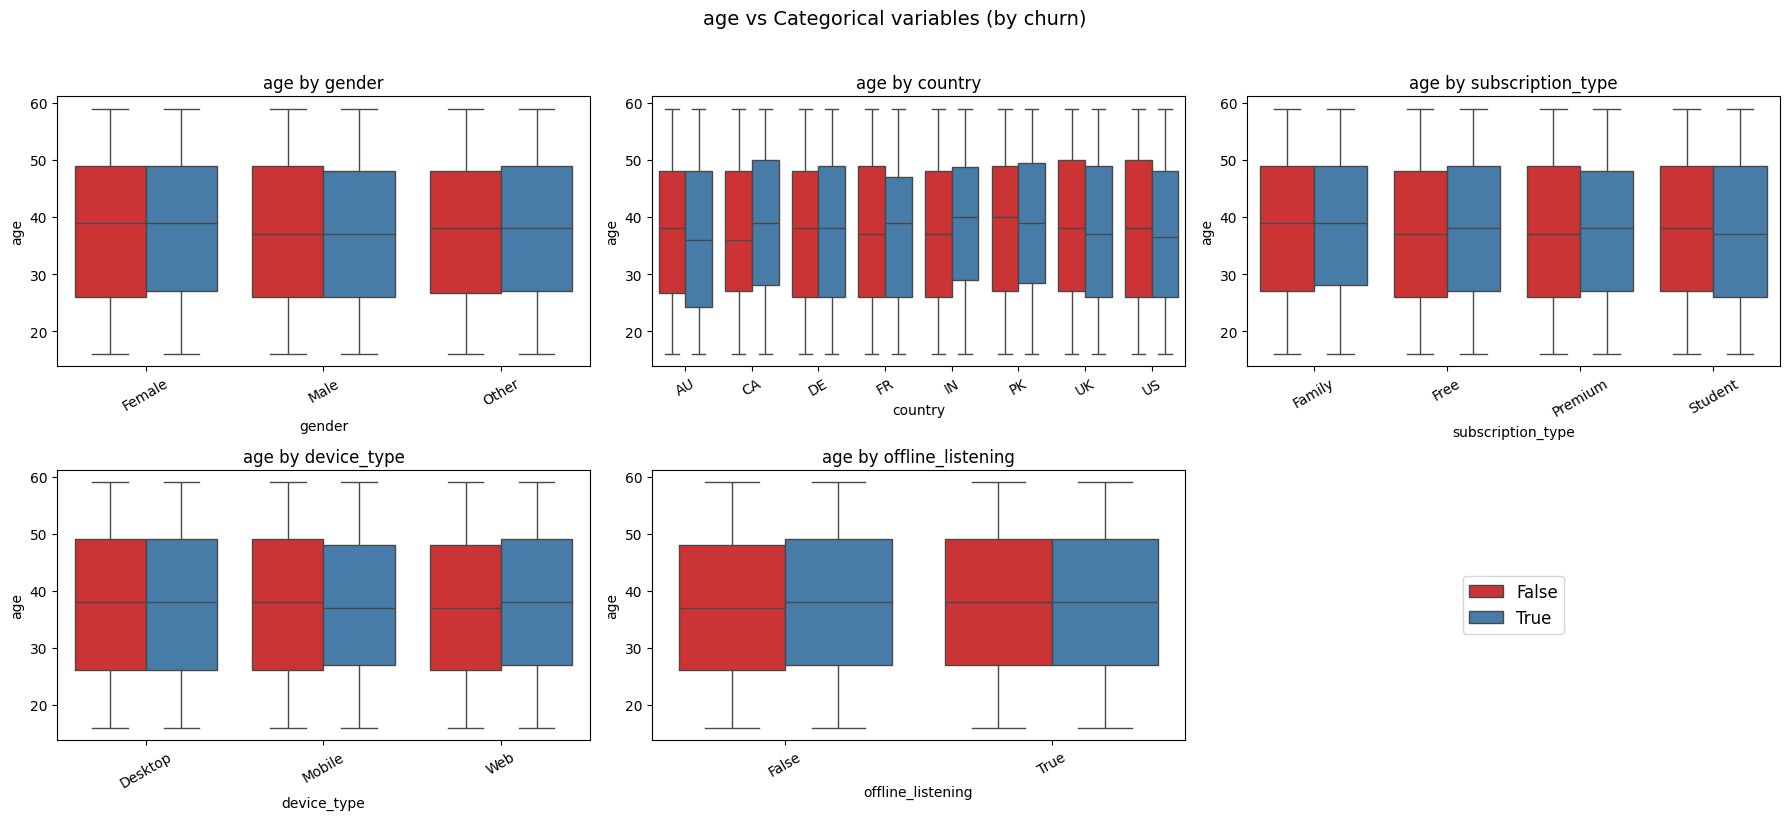

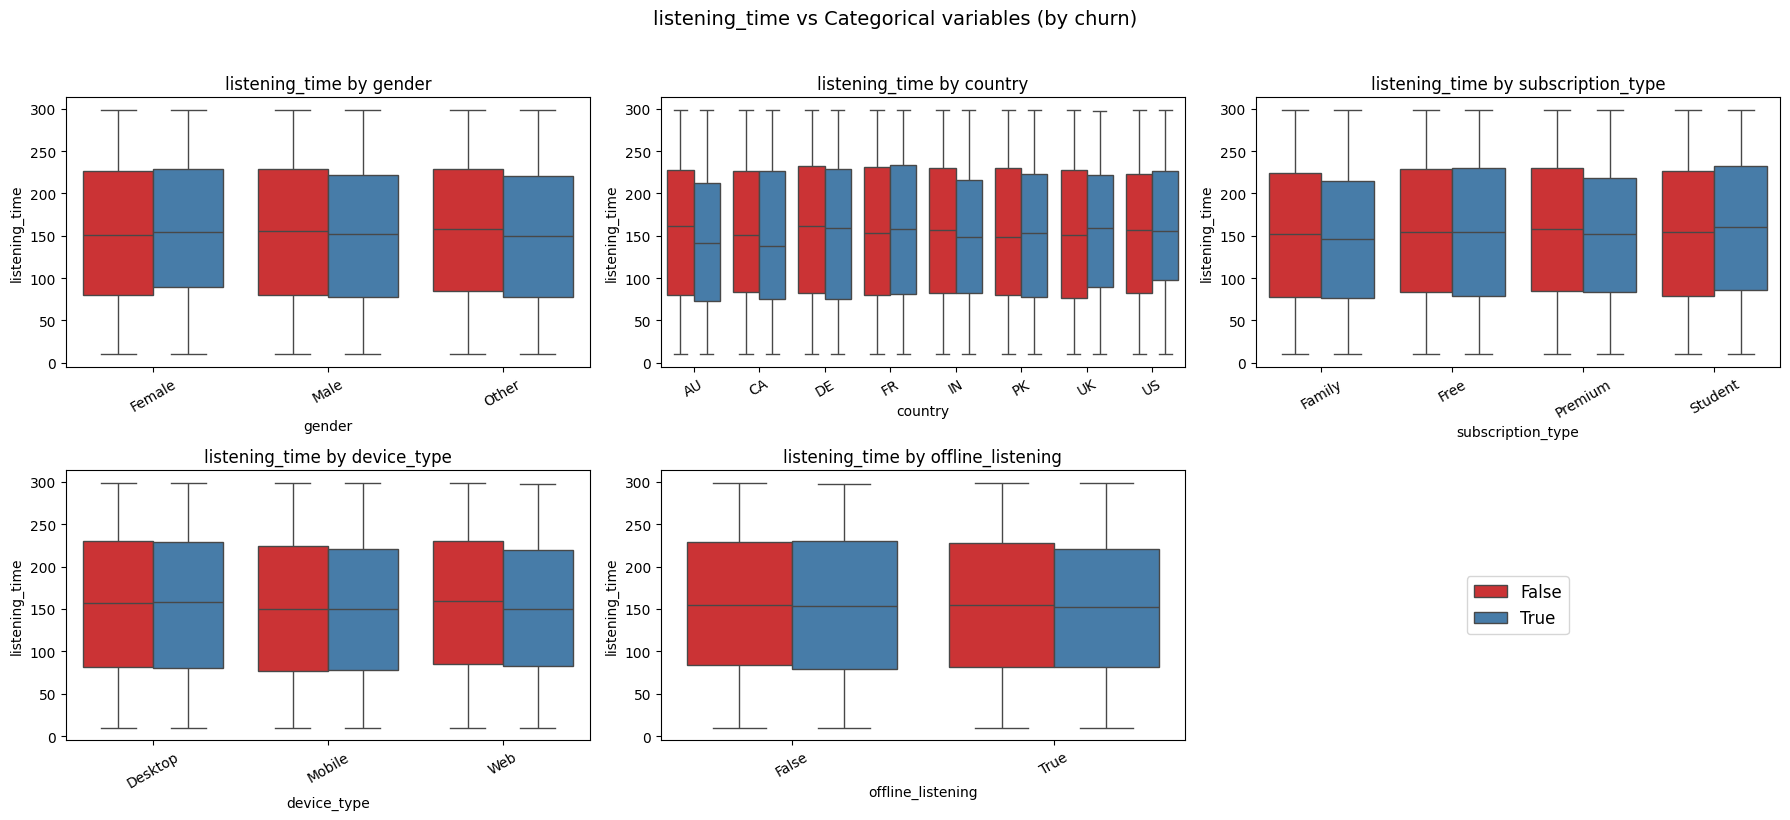

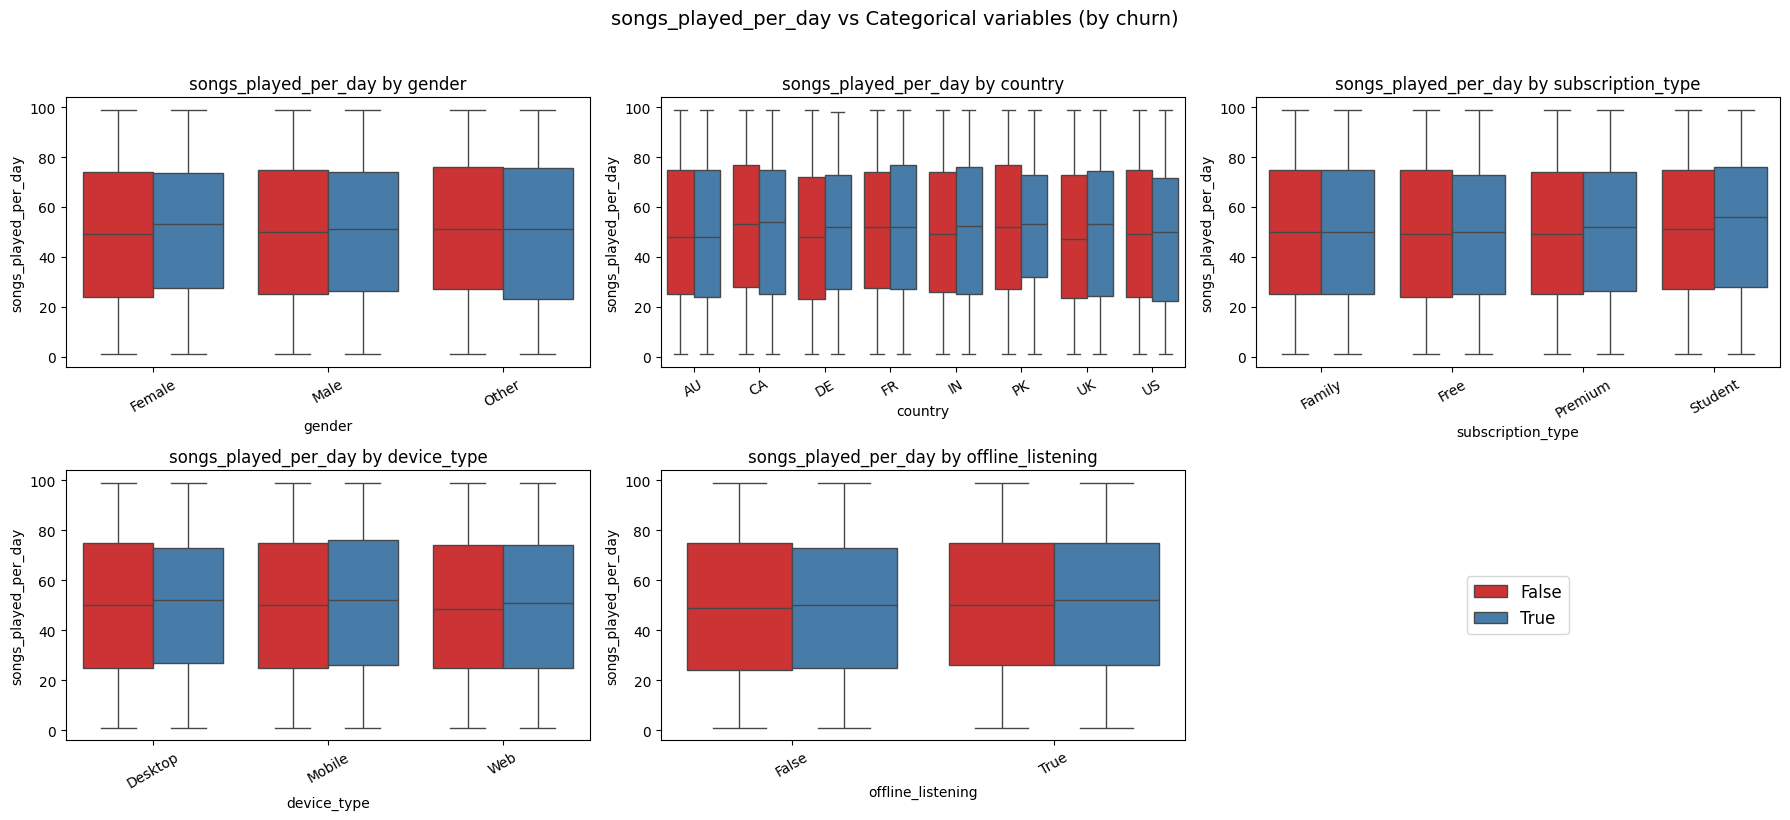

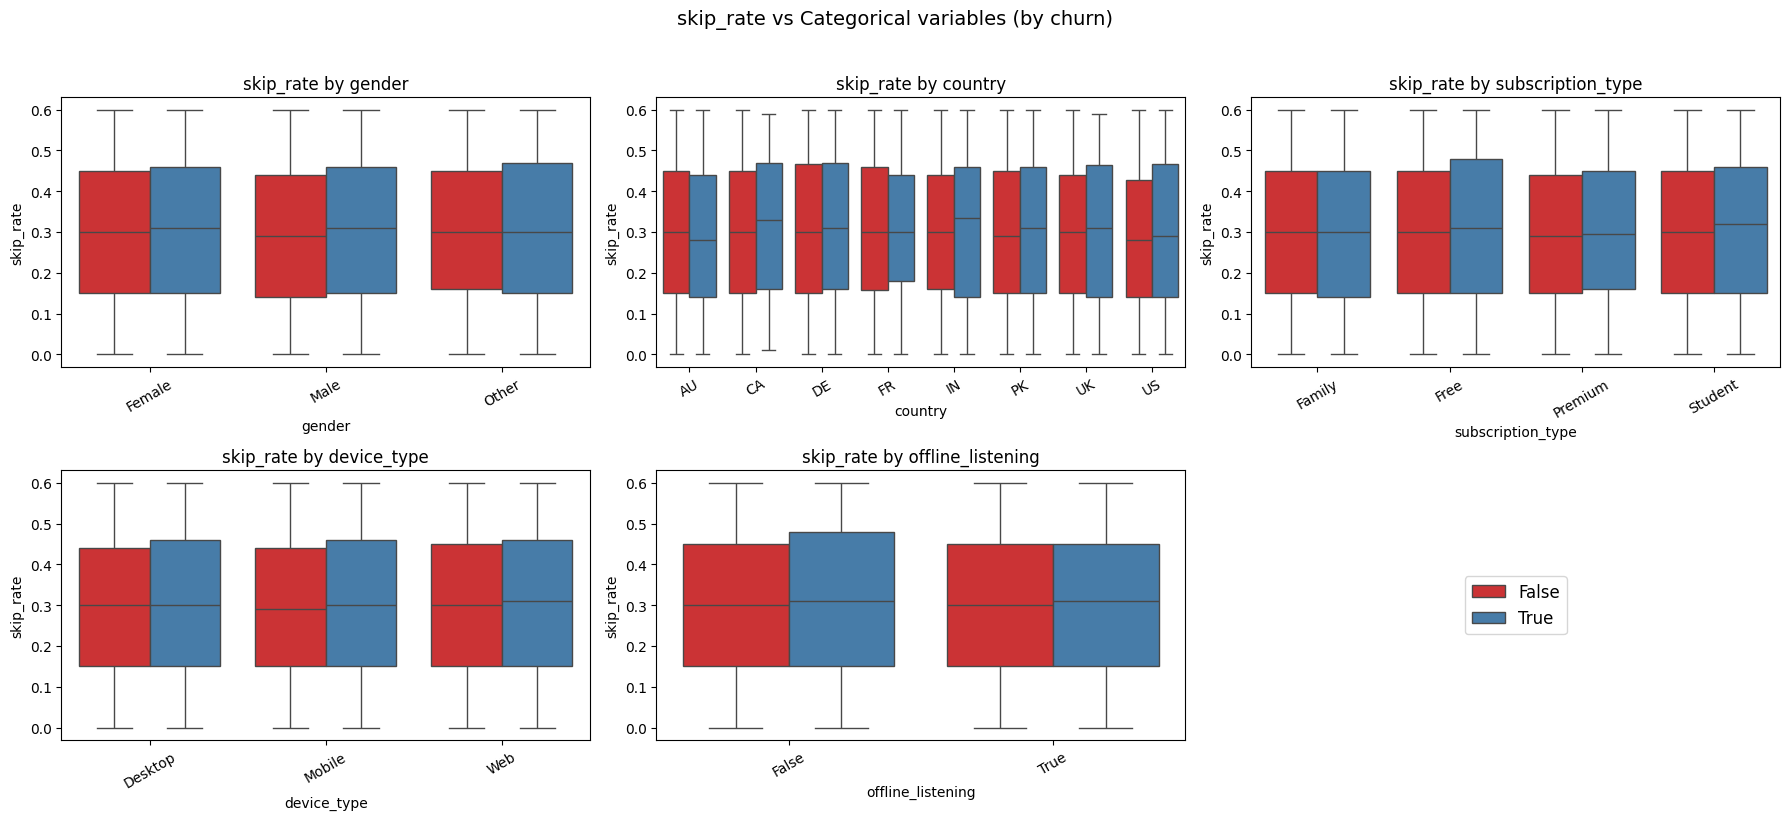

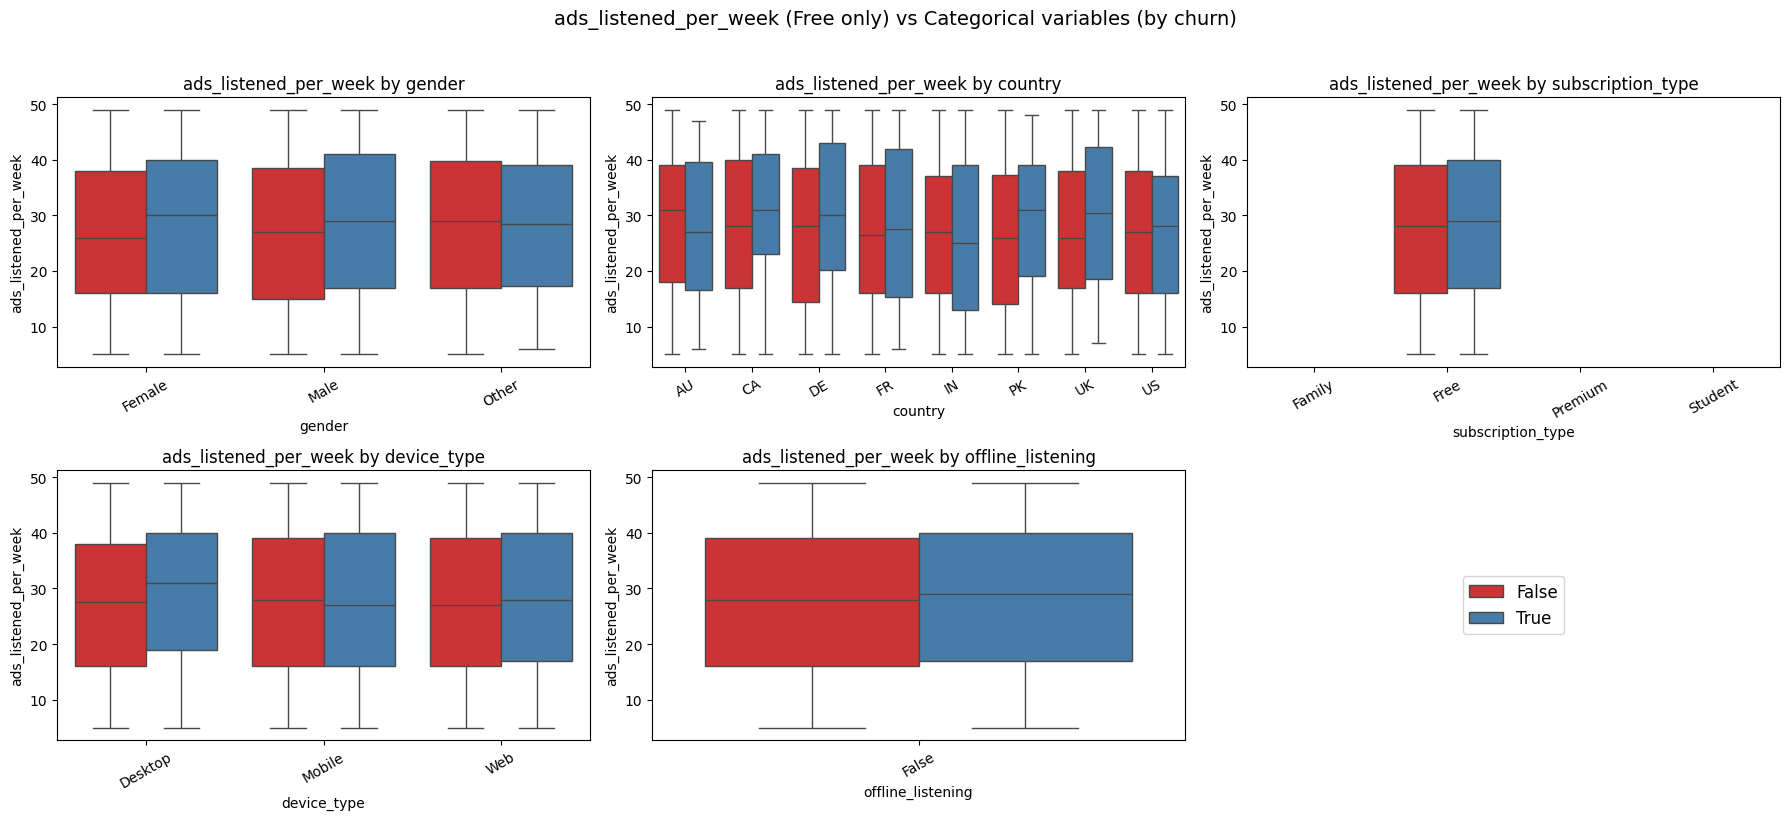

In [17]:
# Categorical list excluding ids
cat_features = [c for c in (categorical_cols + string_cols + boolean_cols) if c not in ["user_id"]]

# Loop numeric - categoric
for num_col in quantitative_cols:
    ncols = 3
    nrows = int(len(cat_features) / ncols) + (len(cat_features) % ncols > 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.flatten()

    for i, cat_col in enumerate(cat_features):
        cols_to_select = list(set([cat_col, num_col, "is_churned"] + 
                                  (["subscription_type"] if num_col == "ads_listened_per_week" else [])))
        
        plot_df = df_raw[cols_to_select].dropna().copy()

        # Filter: only Free when ads
        if num_col == "ads_listened_per_week":
            plot_df = plot_df[plot_df["subscription_type"] == "Free"]

        plot_df[cat_col] = pd.Categorical(plot_df[cat_col])

        sns.boxplot(
            data=plot_df,
            x=cat_col,
            y=num_col,
            hue="is_churned",
            palette="Set1",
            ax=axes[i]
        )
        axes[i].set_title(f"{num_col} by {cat_col}")
        axes[i].tick_params(axis='x', rotation=30)
        axes[i].legend_.remove()  

    if len(cat_features) < len(axes):
        legend_ax = axes[-1]
        legend_ax.axis("off")  # quitar ejes
        handles, labels = axes[0].get_legend_handles_labels()
        legend_ax.legend(handles, labels, loc="center", fontsize=12)

    title_suffix = " (Free only)" if num_col == "ads_listened_per_week" else ""
    plt.suptitle(f"{num_col}{title_suffix} vs Categorical variables (by churn)", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


# 4. **Preprocessing and Feature Engineering**

1. Remove redundant or unnecessary columns: `user_id` and `offline_listening`.  
2. Apply one-hot encoding to categorical variables.  
3. Apply standard scaling to numerical variables.  


In [18]:
# 1. Remove redundant or unnecessary columns
df_model = df_raw.drop(columns=["user_id", "offline_listening"])


In [19]:
# 2. One hot encoding
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)


In [20]:
# 3. Standar Scaler
scaler = StandardScaler()
df_model[quantitative_cols] = scaler.fit_transform(df_model[quantitative_cols])

# 5. **Split dataset**

In [21]:
# Target
y = df_model["is_churned"]

# Features
X = df_model.drop(columns=["is_churned"])

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Churn ratio train:", y_train.mean().round(3))
print("Churn ratio test:", y_test.mean().round(3))

Train shape: (6400, 19)
Test shape: (1600, 19)
Churn ratio train: 0.259
Churn ratio test: 0.259


# 6. **Models**

## A. **Logistic Regression**

The following steps were performed:

1. Define and train the model.  
2. Make predictions.  
3. Evaluate metrics.  
4. Generate the confusion matrix.  

**Results**

- Moderate accuracy (0.518). The model correctly predicts about 52% of the users.  
- High level of false positives (precision = 0.266). Out of every 100 users predicted to churn, only 27 actually do.  
- Recall = 0.49, meaning the model correctly detects about 50% of actual churners.  
- Moderate F1-score, reflecting a balance between precision and recall.  
- ROC-AUC = 0.497, close to random performance.  


=== Logistic Regression Performance ===
Accuracy : 0.518
Precision: 0.266
Recall   : 0.49
F1-score : 0.345
ROC-AUC  : 0.497

=== Classification Report ===
              precision    recall  f1-score   support

       False       0.75      0.53      0.62      1186
        True       0.27      0.49      0.34       414

    accuracy                           0.52      1600
   macro avg       0.51      0.51      0.48      1600
weighted avg       0.62      0.52      0.55      1600



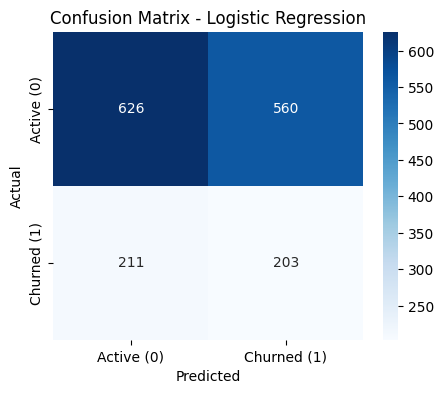

In [ ]:
results = []

# 1. Define and train the model.
log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced"
)  
log_reg.fit(X_train, y_train)

# 2. Predictions.
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# 3. Metrics.
accuracy  = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
recall    = round(recall_score(y_test, y_pred, zero_division=0), 3)
f1        = round(f1_score(y_test, y_pred, zero_division=0), 3)
roc_auc   = round(roc_auc_score(y_test, y_proba), 3)

print("=== Logistic Regression Performance ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("ROC-AUC  :", roc_auc)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

# 4. Confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active (0)", "Churned (1)"],
            yticklabels=["Active (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# 5. Save results
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc
})



## B. **Decision Tree**

1. Define and train the model.  
2. Make predictions.  
3. Evaluate metrics.  
4. Generate the confusion matrix. 
5. Variables importance.

**Results**

- Moderate accuracy (0.515). The model correctly predicts about 52% of the users.  
- High level of false positives (precision = 0.267). Out of every 100 users predicted to churn, only 27 actually do.  
- Recall = 0.502, meaning the model correctly detects about 50% of actual churners.  
- Moderate F1-score, reflecting a balance between precision and recall.  
- ROC-AUC = 0.501, close to random performance.  

- *Skip rate* and *songs played per day* are the most important predictors, followed by *listening time* and *age*. *Ads listened per week* also has some effect.  

=== Decision Tree Performance ===
Accuracy : 0.515
Precision: 0.267
Recall   : 0.502
F1-score : 0.349
ROC-AUC  : 0.501

=== Classification Report ===
              precision    recall  f1-score   support

       False       0.75      0.52      0.61      1186
        True       0.27      0.50      0.35       414

    accuracy                           0.52      1600
   macro avg       0.51      0.51      0.48      1600
weighted avg       0.62      0.52      0.55      1600



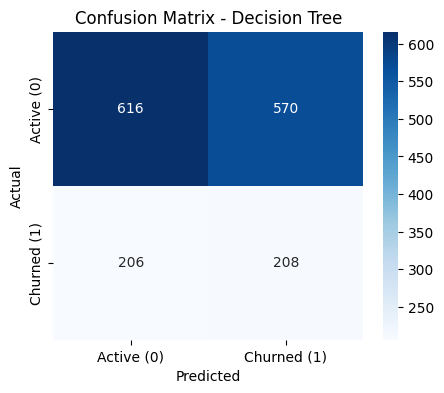

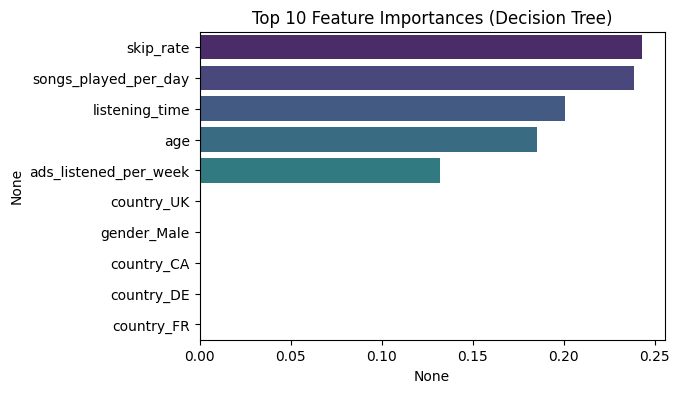

In [ ]:
# 1. Define and train the model.  
tree_clf = DecisionTreeClassifier(
    max_depth=5,          
    class_weight="balanced", 
    random_state=42
)
tree_clf.fit(X_train, y_train)

# 2. Predictions.
y_pred = tree_clf.predict(X_test)
y_proba = tree_clf.predict_proba(X_test)[:, 1]

# 3. Metrics.
accuracy  = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
recall    = round(recall_score(y_test, y_pred, zero_division=0), 3)
f1        = round(f1_score(y_test, y_pred, zero_division=0), 3)
roc_auc   = round(roc_auc_score(y_test, y_proba), 3)

print("=== Decision Tree Performance ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("ROC-AUC  :", roc_auc)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

# 4. Confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active (0)", "Churned (1)"],
            yticklabels=["Active (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# 5. Variables importance.
importances = pd.Series(tree_clf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.show()

# Save results
results.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc
})

## C. **Random Forest**

1. Define and train the model.  
2. Predictions.
3. Metrics.
4. Confusion matrix.
5. Variables importance.

**Results**

- High accuracy (0.725). However, this is mainly due to the model correctly predicting the majority class.  
- High level of false positives (precision = 0.297). Out of every 100 users predicted to churn, only 30 actually do.  
- Recall = 0.046, meaning the model fails to detect most actual churners.  
- F1-score is nearly null, reflecting the poor balance between precision and recall.  
- ROC-AUC = 0.53, only slightly better than random performance.  

- *Listening time*, *songs played per day*, *skip rate*, and *age* are the most important predictors. *Ads listened per week* also has some effect.  


=== Random Forest Performance ===
Accuracy : 0.725
Precision: 0.297
Recall   : 0.046
F1-score : 0.079
ROC-AUC  : 0.53

=== Classification Report ===
              precision    recall  f1-score   support

       False       0.74      0.96      0.84      1186
        True       0.30      0.05      0.08       414

    accuracy                           0.72      1600
   macro avg       0.52      0.50      0.46      1600
weighted avg       0.63      0.72      0.64      1600



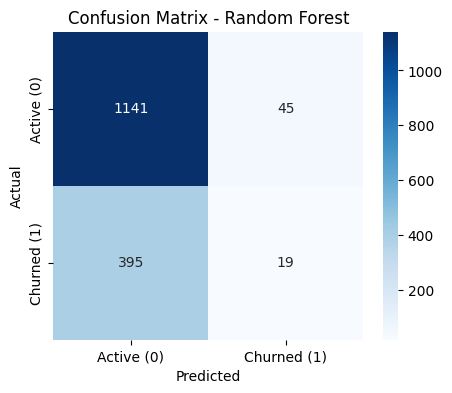

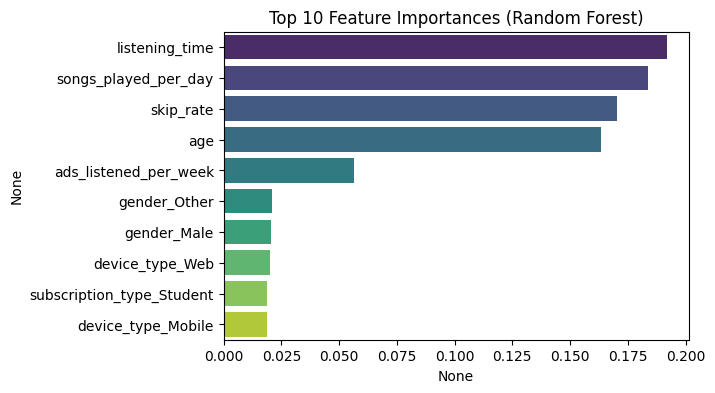

In [ ]:
# 1. Define and train the model.  
rf_clf = RandomForestClassifier(
    n_estimators=200,      
    max_depth=None,        
    min_samples_split=10,  
    class_weight="balanced",
    random_state=42,
    n_jobs=-1              
)
rf_clf.fit(X_train, y_train)

# 2. Predictions.
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]

# 3. Metrics.
accuracy  = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
recall    = round(recall_score(y_test, y_pred, zero_division=0), 3)
f1        = round(f1_score(y_test, y_pred, zero_division=0), 3)
roc_auc   = round(roc_auc_score(y_test, y_proba), 3)

print("=== Random Forest Performance ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("ROC-AUC  :", roc_auc)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

# 4. Confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active (0)", "Churned (1)"],
            yticklabels=["Active (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# 5. Variables importance.
importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

# Save results
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc
})

## D. **XGBoost**

1. Define and train the model. 
2. Predictions.
3. Metrics.
4. Confusion matrix.
5. Variables importance.

**Results**

- Moderate accuracy (0.612). The model correctly predicts about 61% of the cases.  
- High level of false positives (precision = 0.282). Out of every 100 users predicted to churn, only 28 actually do.  
- Recall = 0.324, meaning the model detects about 32% of actual churners.  
- Low F1-score, reflecting the weak balance between precision and recall.  
- ROC-AUC = 0.516, close to random performance.  

- *Country* is the most important predictor, followed by *songs played per day* and *listening time*. *Skip rate* and *age* also show some importance.  

=== XGBoost Performance ===
Accuracy : 0.612
Precision: 0.282
Recall   : 0.324
F1-score : 0.301
ROC-AUC  : 0.516

=== Classification Report ===
              precision    recall  f1-score   support

       False       0.75      0.71      0.73      1186
        True       0.28      0.32      0.30       414

    accuracy                           0.61      1600
   macro avg       0.52      0.52      0.52      1600
weighted avg       0.63      0.61      0.62      1600



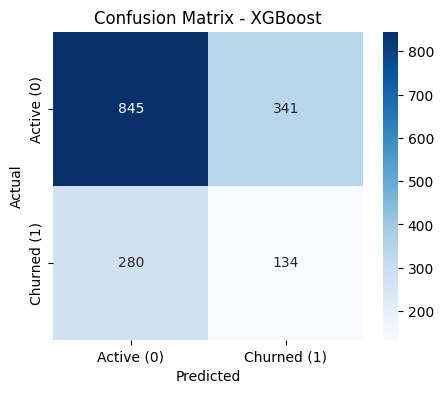

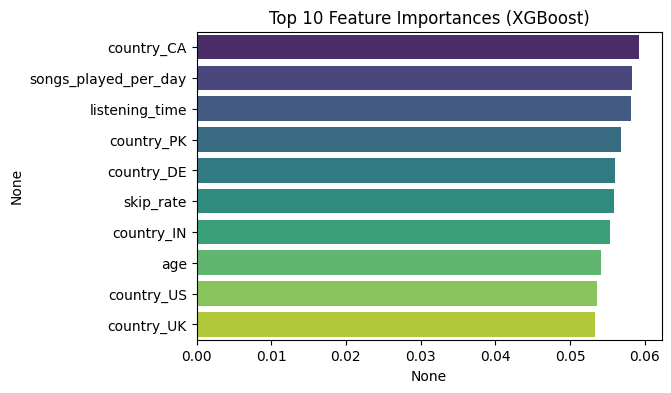

In [ ]:
# Class proportion for scale_pos_weight
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# 1. Define and train the model. 
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos, 
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_clf.fit(X_train, y_train)

# 2. Predictions.
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# 3. Metrics.
accuracy  = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
recall    = round(recall_score(y_test, y_pred, zero_division=0), 3)
f1        = round(f1_score(y_test, y_pred, zero_division=0), 3)
roc_auc   = round(roc_auc_score(y_test, y_proba), 3)

print("=== XGBoost Performance ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("ROC-AUC  :", roc_auc)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

# 4. Confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active (0)", "Churned (1)"],
            yticklabels=["Active (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# 5. Variables importance.
importances = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

# Save
results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc
})

# 7. Conclusions

If the business goal is to detect churners even at the cost of generating false positives, the **Decision Tree** is the most suitable starting point:

- Recall ≈ 50% (it identifies about half of the churners).  
- Easy to interpret, which helps explain churn patterns.  

If the goal is to achieve a balance between recall and stability, then **XGBoost** is the preferred model, although the results remain modest (recall ≈ 32%).  

In any case, the current models are not sufficiently robust to provide reliable churn prediction in a production setting.  


In [26]:
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision  Recall  F1-score  ROC-AUC
0  Logistic Regression     0.518      0.266   0.490     0.345    0.497
1        Decision Tree     0.515      0.267   0.502     0.349    0.501
2        Random Forest     0.725      0.297   0.046     0.079    0.530
3              XGBoost     0.612      0.282   0.324     0.301    0.516
